In [1]:
import os
import cv2
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [3]:
# device = torch.device("cuda")

In [4]:
def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

In [5]:
wing_1 = Image.open('../testdata/set_1/043870_L_O.JPG')
wing_2 = Image.open('../testdata/set_1/043870_R_O.JPG')
wing_3 = Image.open('../testdata/set_1/043874_L_O.JPG')
wing_4 = Image.open('../testdata/set_1/043874_R_O.JPG')
wing_5 = Image.open('../testdata/set_1/043878_L_O.JPG')
wing_6 = Image.open('../testdata/set_1/043878_R_O.JPG')
wing_7 = Image.open('../testdata/set_1/043884_L_O.JPG')

wing = wing_3
wing = np.array(wing.convert("RGB"))

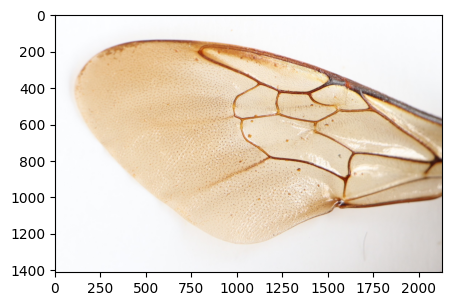

In [6]:
plt.figure(figsize=(5, 5))
plt.imshow(wing)
plt.axis('on')
plt.show()

In [7]:
?SAM2AutomaticMaskGenerator

Object `SAM2AutomaticMaskGenerator` not found.


In [10]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
import time

sam2_checkpoint = "/home/wsl/bin/segment-anything-2/checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

start = time.time()
sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2,
    min_mask_region_area=500.0
)

masks2 = mask_generator_2.generate(wing)

end = time.time()
print(round(end - start, 2), "seconds")

18.67 seconds


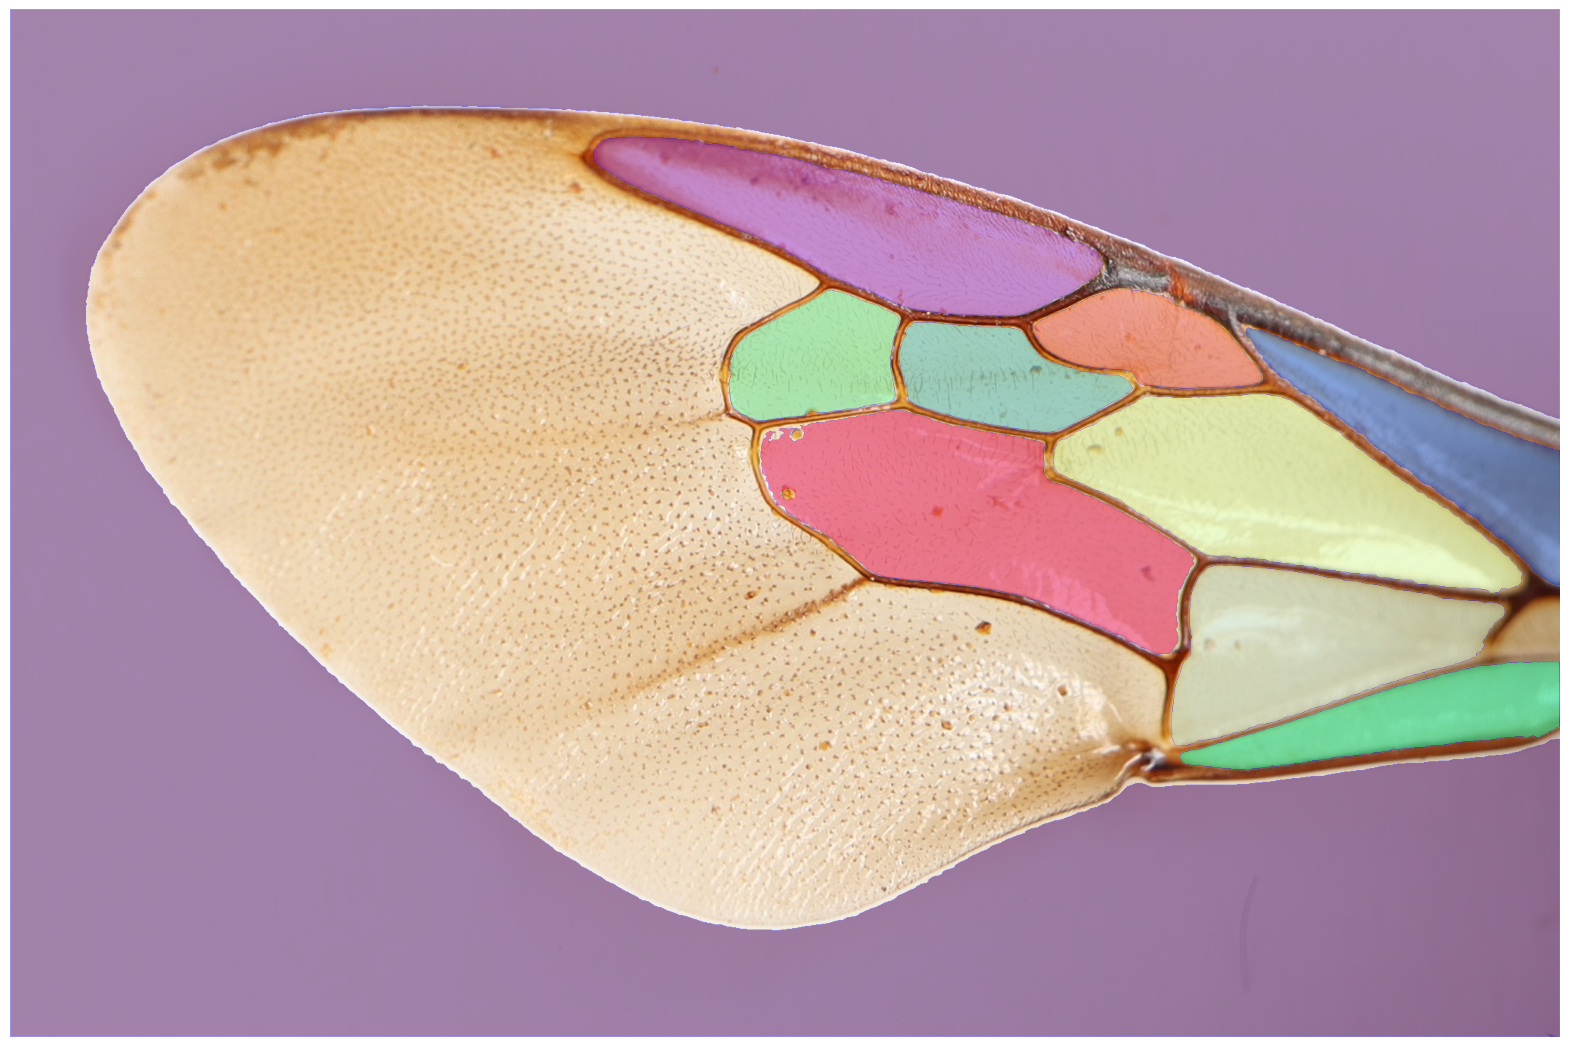

In [11]:
plt.figure(figsize=(20, 20))
plt.imshow(wing)
show_anns(masks2)
plt.axis('off')
plt.show() 

In [ ]:
for i, mask in enumerate(masks2):
    print(f"Size of label {i}:\t{mask['area']} pixels")